In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Load saved predictions
logreg_probs = np.load("../outputs/logreg_probs.npy")
bert_probs = np.load("../outputs/toxic_bert_preds.npy")

# Load true labels (optional reload if needed)
df = pd.read_csv("../data/train.csv")
df = df.dropna(subset=["comment_text"])
df["clean_comment"] = df["comment_text"].str.lower().str.replace(r"[^a-z\s]", "", regex=True)
y = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
_, y_test = train_test_split(y, test_size=0.2, random_state=42)
y_true = y_test.values


*F1-Score Bar Chart (LogReg vs BERT)*

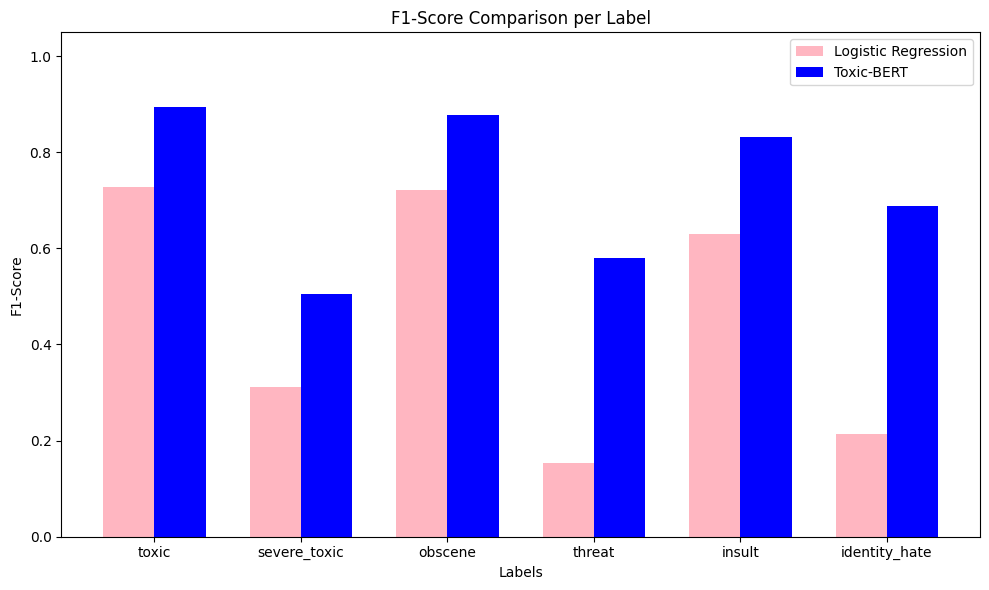

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Define labels
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Threshold to get binary predictions
logreg_preds = (logreg_probs >= 0.5).astype(int)
bert_preds = (bert_probs >= 0.5).astype(int)

# Calculate F1-scores
f1_logreg = [f1_score(y_true[:, i], logreg_preds[:, i]) for i in range(6)]
f1_bert = [f1_score(y_true[:, i], bert_preds[:, i]) for i in range(6)]

# Bar chart
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, f1_logreg, width, label='Logistic Regression', color='lightpink')
plt.bar(x + width/2, f1_bert, width, label='Toxic-BERT', color='blue')

plt.xlabel("Labels")
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison per Label")
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


*Multi-label ROC-AUC Curves (LogReg vs BERT)*

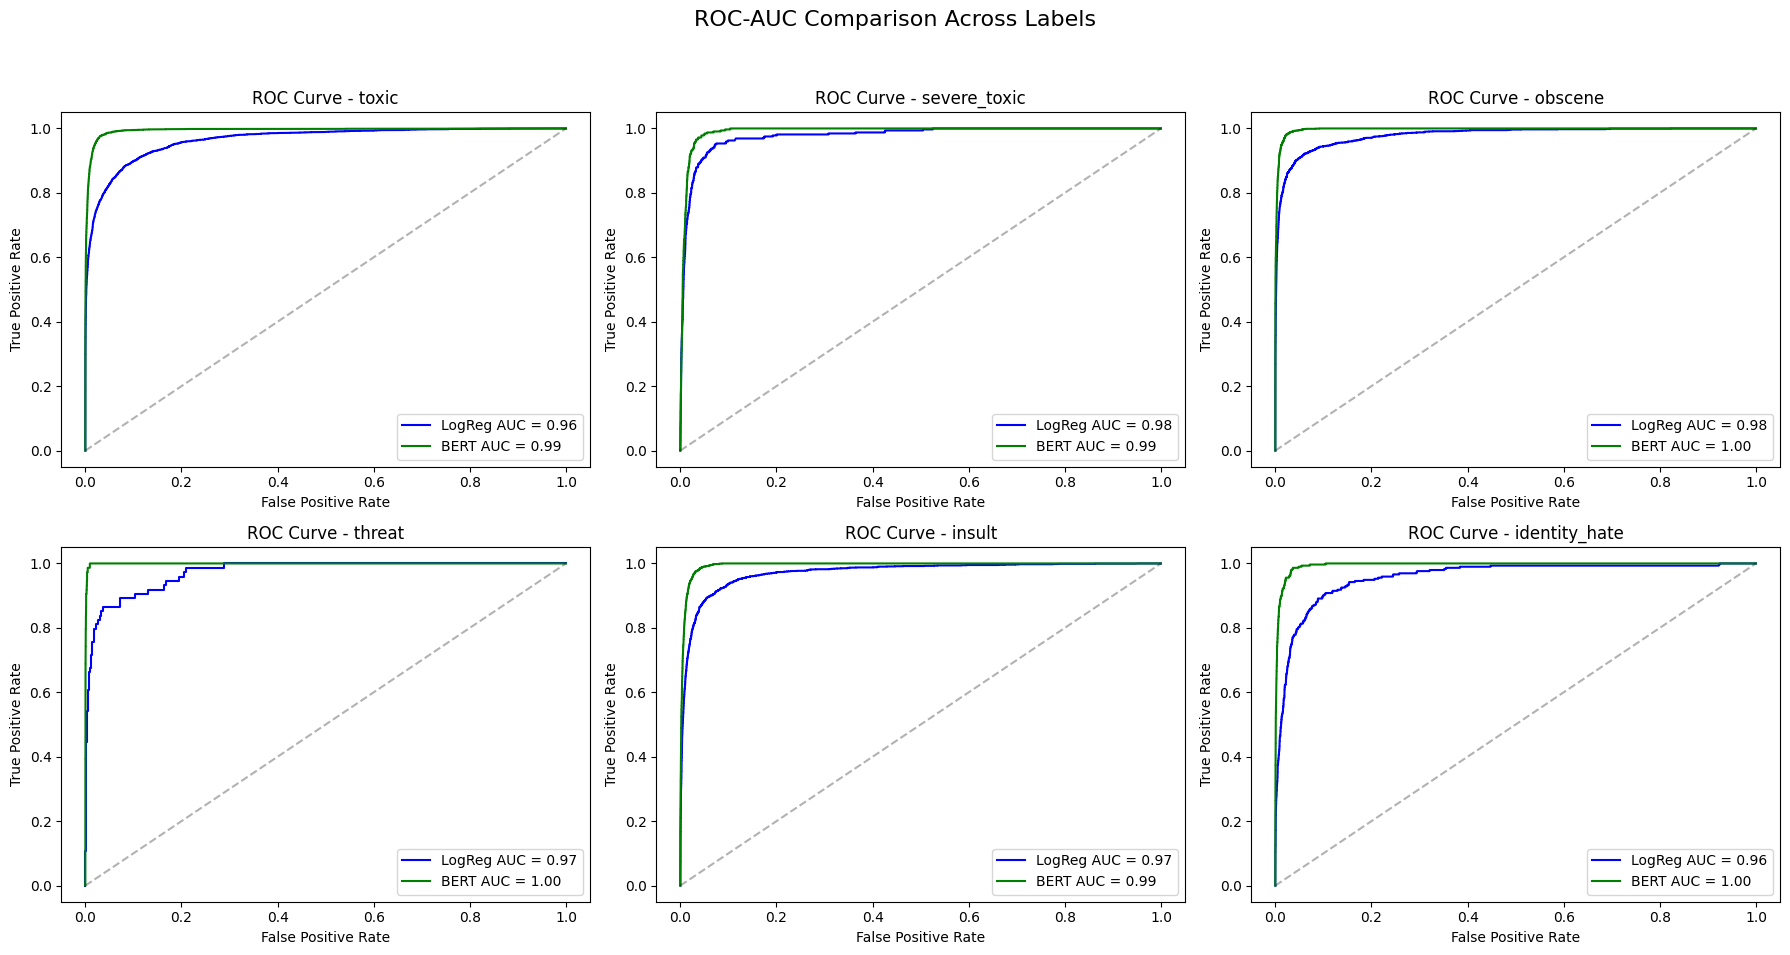

In [11]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i, label in enumerate(labels):
    ax = axes[i//3, i%3]
    
    # Logistic Regression
    fpr_log, tpr_log, _ = roc_curve(y_true[:, i], logreg_probs[:, i])
    auc_log = auc(fpr_log, tpr_log)
    
    # BERT
    fpr_bert, tpr_bert, _ = roc_curve(y_true[:, i], bert_probs[:, i])
    auc_bert = auc(fpr_bert, tpr_bert)
    
    ax.plot(fpr_log, tpr_log, label=f'LogReg AUC = {auc_log:.2f}', color='blue')
    ax.plot(fpr_bert, tpr_bert, label=f'BERT AUC = {auc_bert:.2f}', color='green')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    
    ax.set_title(f"ROC Curve - {label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()

plt.suptitle("ROC-AUC Comparison Across Labels", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [13]:
from sklearn.metrics import roc_auc_score

# F1 scores were computed earlier
# Now compute AUCs for both models
auc_logreg = [roc_auc_score(y_true[:, i], logreg_probs[:, i]) for i in range(6)]
auc_bert = [roc_auc_score(y_true[:, i], bert_probs[:, i]) for i in range(6)]

# Build summary table
df_metrics = pd.DataFrame({
    "Label": labels,
    "F1_LogReg": [round(score, 2) for score in f1_logreg],
    "F1_BERT": [round(score, 2) for score in f1_bert],
    "F1_Lift": [round(b - l, 2) for l, b in zip(f1_logreg, f1_bert)],
    "AUC_LogReg": [round(score, 2) for score in auc_logreg],
    "AUC_BERT": [round(score, 2) for score in auc_bert],
    "AUC_Lift": [round(b - l, 2) for l, b in zip(auc_logreg, auc_bert)],
})

df_metrics


,Label,F1_LogReg,F1_BERT,F1_Lift,AUC_LogReg,AUC_BERT,AUC_Lift
0,toxic,0.73,0.90,0.17,0.96,0.99,0.03
1,severe_toxic,0.31,0.50,0.19,0.98,0.99,0.01
2,obscene,0.72,0.88,0.16,0.98,1.00,0.02
3,threat,0.15,0.58,0.43,0.97,1.00,0.03
4,insult,0.63,0.83,0.20,0.97,0.99,0.02
5,identity_hate,0.21,0.69,0.47,0.96,1.00,0.04
